In [1]:
import mxnet as mx
from mxnet import gluon

from matplotlib import pyplot as plt
import numpy as np
import cv2

from cnnviz.layers import Activation, Conv2D
from cnnviz import cnnviz

Build the network you want to visualize. Import `Activation` and `Conv2D` from `cnnviz.layers` instead of `gluon.nn`. Relu actvation has been modified to make negative gradients zero. `Conv2D` has been modified to record gradients of the output of the specified convolution layer.

In [2]:
import os
from mxnet.gluon.model_zoo import model_store

from mxnet.gluon.nn import MaxPool2D, Flatten, Dense, Dropout
from cnnviz.layers import Activation, Conv2D

class AlexNet(mx.gluon.HybridBlock):
    def __init__(self, classes=1000, **kwargs):
        super(AlexNet, self).__init__(**kwargs)
        with self.name_scope():
            self.features = gluon.nn.HybridSequential(prefix='')
            with self.features.name_scope():
                self.features.add(Conv2D(64, kernel_size=11, strides=4, padding=2))
                self.features.add(Activation('relu'))
                self.features.add(MaxPool2D(pool_size=3, strides=2))

                self.features.add(Conv2D(192, kernel_size=5, padding=2))
                self.features.add(Activation('relu'))
                self.features.add(MaxPool2D(pool_size=3, strides=2))

                self.features.add(Conv2D(384, kernel_size=3, padding=1))
                self.features.add(Activation('relu'))

                self.features.add(Conv2D(256, kernel_size=3, padding=1))
                self.features.add(Activation('relu'))

                self.features.add(Conv2D(256, kernel_size=3, padding=1))
                self.features.add(Activation('relu'))
                self.features.add(MaxPool2D(pool_size=3, strides=2))

                self.features.add(Flatten())

                self.features.add(Dense(4096))
                self.features.add(Activation('relu'))
                self.features.add(Dropout(0.5))

                self.features.add(Dense(4096))
                self.features.add(Activation('relu'))
                self.features.add(Dropout(0.5))

            self.output = Dense(classes)

    def hybrid_forward(self, F, x):
        x = self.features(x)
        x = self.output(x)
        return x

def build_alexnet(pretrained=False, ctx=mx.cpu(),
            root=os.path.join('~', '.mxnet', 'models'), **kwargs):
    net = AlexNet(**kwargs)
    if pretrained:
        net.load_params(model_store.get_model_file('alexnet', root=root), ctx=ctx)
    return net

In [3]:
image_sz = (224, 224)

def preprocess(data):
    data = mx.image.imresize(data, image_sz[0], image_sz[1])
    data = data.astype(np.float32)
    data = data/255
    data = mx.image.color_normalize(data,
                                    mean=mx.nd.array([0.485, 0.456, 0.406]),
                                    std=mx.nd.array([0.229, 0.224, 0.225]))
    data = mx.nd.transpose(data, (2,0,1))
    return data

alexnet = build_alexnet(pretrained=True)
last_conv_layer_name = 'alexnet0_conv2d4'

In [4]:
def read_image_mxnet(path):
    with open(path, 'rb') as fp:
        img_bytes = fp.read()
    return mx.img.imdecode(img_bytes)

def read_image_cv(path):
    return cv2.resize(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB), image_sz)

In [5]:
def visualize(net, img_path, conv_layer_name):
    image = read_image_mxnet(img_path)
    image = preprocess(image)
    image = image.expand_dims(axis=0)    
    orig_img = read_image_cv(img_path)
    vizs = cnnviz.visualize_class_activation(net, image, orig_img, conv_layer_name)
    return (orig_img, *vizs)

In [13]:
def show_images(images):
    titles = ['Original', 'Grad-CAM', 'Guided Grad-CAM', 'Saliency']
    num_images = len(images)
    fig=plt.figure(figsize=(15,15))
    rows, cols = 1, num_images
    for i in range(num_images):
        fig.add_subplot(rows, cols, i+1)
        plt.xlabel(titles[i])
        plt.imshow(images[i], cmap='gray' if i==3 else None)
    plt.show()

In [14]:
alexnet.features[10]._name

'alexnet0_conv2d4'

In [15]:
with open("img/tiger.jpg", 'rb') as fp:
    str_image = fp.read()

image = mx.img.imdecode(str_image)
image = preprocess(image)
image = image.expand_dims(axis=0)

out = alexnet(image)
out.argmax(axis=1)


[292.]
<NDArray 1 @cpu(0)>

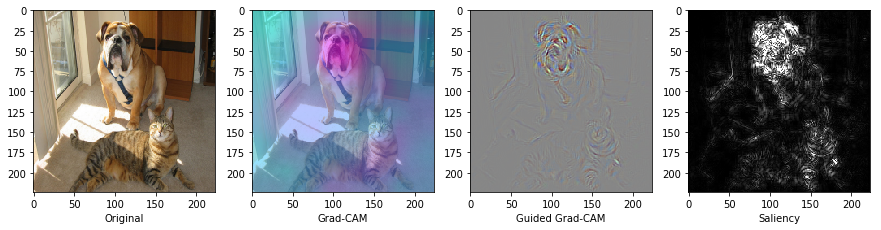

In [16]:
show_images(visualize(alexnet, "img/cat_dog.png", last_conv_layer_name))

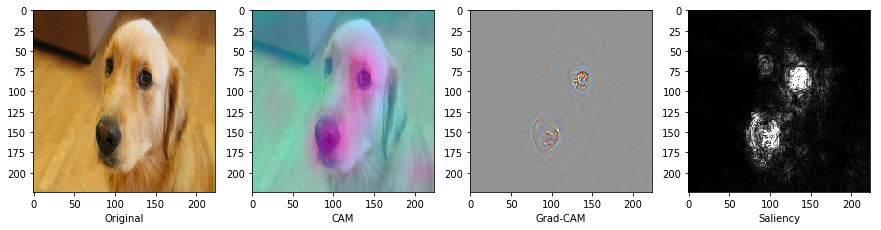

In [11]:
show_images(visualize(alexnet, "img/dog2.jpg", last_conv_layer_name))

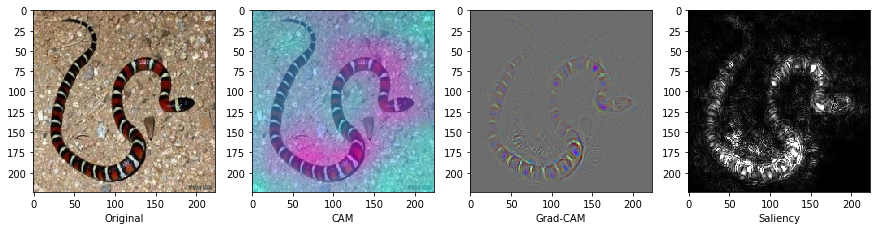

In [12]:
show_images(visualize(alexnet, "img/snake.jpg", last_conv_layer_name))